In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as snsç
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns

In [2]:
from sqlalchemy import create_engine
import pandas as pd

HOST="192.53.165.168"
DBNAME="taxisdb"
USER="airflow"
PASS="airflow"
BATCH_SIZE_TRIP=100000
DATABASE_LOCATION=f'postgresql+psycopg2://{USER}:{PASS}@{HOST}:5432/{DBNAME}'

query="""
SELECT
    id_rate ,
    trip_distance,
    tiempo_viaje,
    pu_b.id_borough as pu_borough,
    do_b.id_borough as do_borough,
    fare_amount
FROM trip
JOIN location pu_l on pu_l.id_location = trip.pu_location
JOIN location do_l on do_l.id_location = trip.do_location
JOIN borough pu_b on pu_b.id_borough = pu_l.id_borough
JOIN borough do_b on do_b.id_borough = do_l.id_borough
"""

In [3]:
engine= create_engine(DATABASE_LOCATION)
with engine.connect()  as conn:
    df_trip=pd.read_sql(query,conn)
df_trip.head()

,id_rate,trip_distance,tiempo_viaje,pu_borough,do_borough,fare_amount
0,1,2.3,1078.0,1,1,12.5
1,1,3.8,1789.0,1,1,19.5
2,1,0.7,293.0,1,1,5.0
3,1,2.8,1176.0,1,1,13.5
4,1,1.3,748.0,1,1,9.0


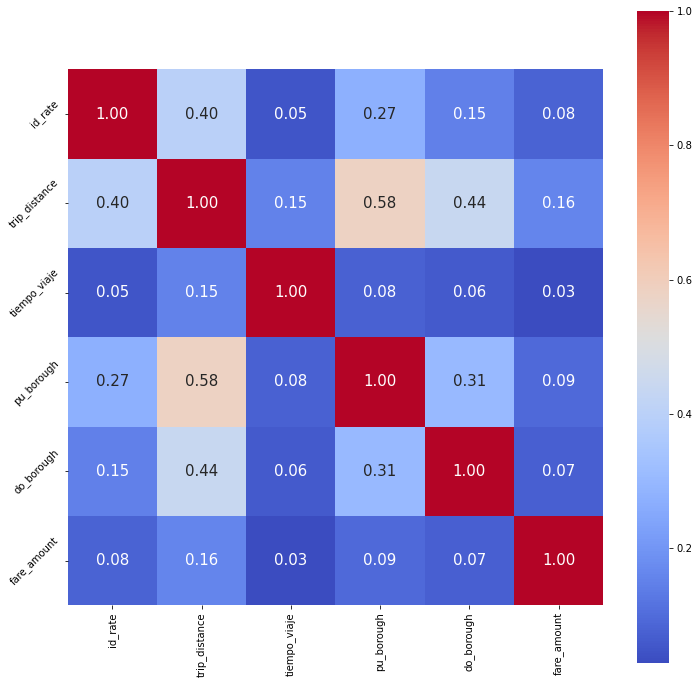

In [6]:
corr = df_trip.corr()  #is used for find corelation
plt.figure(figsize=(12,12))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           cmap= 'coolwarm')
plt.xticks(rotation = 90)
plt.yticks(rotation = 45)
plt.show()

### Arbol de desicion

In [16]:
df_trip

,id_rate,trip_distance,tiempo_viaje,pu_borough,do_borough,fare_amount
0,1,2.3,1078.0,1,1,12.5
1,1,3.8,1789.0,1,1,19.5
2,1,0.7,293.0,1,1,5.0
3,1,2.8,1176.0,1,1,13.5
4,1,1.3,748.0,1,1,9.0
...,...,...,...,...,...,...
26092492,1,1.1,1049.0,1,1,11.5
26092493,1,2.0,976.0,1,1,11.5
26092494,1,0.6,352.0,1,1,5.5
26092495,1,1.3,565.0,1,1,8.0


In [11]:
x_train, x_test, y_train, y_test= train_test_split(df_trip[["id_rate","trip_distance","pu_borough","do_borough"]],df_trip["fare_amount"],test_size=0.2)
x_train

,id_rate,trip_distance,pu_borough,do_borough
8144087,1,0.97,1,1
2935415,1,1.29,1,1
12219601,1,5.20,1,1
3869788,1,1.50,1,1
15014165,1,1.25,1,1
...,...,...,...,...
9582934,1,2.40,1,1
6100821,1,3.51,1,1
7726256,1,1.90,1,1
10891043,1,4.10,1,1


In [7]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
import numpy as np

In [8]:
from sklearn.model_selection import GridSearchCV
#parameters = {'min_samples_split':[1000],'min_samples_split':[1000,10000],'max_depth':[3]}
parameters = {'min_samples_split':[200,500,1000],'min_samples_leaf':[200,500,1000],'max_depth':[10,20,30]}

In [9]:
regtree = DecisionTreeRegressor()

In [73]:
clf = GridSearchCV(regtree, parameters)
clf.fit(x_train,y_train)

GridSearchCV(estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [10, 20, 30],
                         'min_samples_leaf': [200, 500, 1000],
                         'min_samples_split': [200, 500, 1000]})

In [74]:
clf.best_params_

{'max_depth': 20, 'min_samples_leaf': 1000, 'min_samples_split': 200}

In [10]:
regtree = DecisionTreeRegressor(min_samples_split=200, min_samples_leaf=1000, max_depth=20)
regtree.fit(x_train,y_train)
regtree.score(x_test,y_test)

NameError: name 'x_train' is not defined

In [12]:
cv = KFold(n_splits = 50, shuffle=True, random_state=1)
cv.get_n_splits(x_train)
scores = cross_val_score(regtree, x_train, y_train, cv = cv, n_jobs=5)
print(scores)
score = np.mean(scores)
print(score)

[9.23858262e-01 9.15038744e-01 9.36131222e-01 8.88690026e-01
 9.27690476e-01 9.22462646e-01 8.87309536e-01 7.91925927e-01
 7.10418202e-01 9.00150075e-01 9.29000352e-01 9.40652640e-01
 9.37034294e-01 9.29444900e-01 9.06101580e-01 7.86985757e-01
 9.34488934e-01 9.40807952e-01 9.32840767e-01 9.27165289e-01
 9.13140480e-01 9.30735548e-01 9.30870577e-01 9.36501688e-01
 9.07973786e-04 9.36938488e-01 7.68132600e-01 9.12220917e-01
 9.36987425e-01 9.04459817e-01 9.31065779e-01 7.68194341e-01
 9.36331976e-01 9.22869753e-01 9.33672296e-01 9.12266061e-01
 9.06656267e-01 9.30891566e-01 9.38980133e-01 9.12723496e-01
 9.27738831e-01 9.38379976e-01 9.27254866e-01 9.27748043e-01
 7.93357585e-01 7.95134704e-01 6.75521137e-01 9.35184877e-01
 8.98529856e-01 9.34012557e-01]
0.879712143876753


In [15]:
from sklearn.metrics import mean_squared_error
y_train_pred = regtree.predict(x_train)
y_test_pred = regtree.predict(x_test)
print('Error en datos de train:', mean_squared_error(y_train, y_train_pred))
print('Error en datos de test:', mean_squared_error(y_test, y_test_pred))

Error en datos de train: 2219.3557079409306
Error en datos de test: 7679.429523458934


In [111]:
X_new=[[1, 2.0,1,1]]
regtree.predict(X_new)

c:\Users\Nacho\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


array([10.55818523])

In [22]:
import pandas
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
import pickle

In [23]:
filename = 'finalized_regtree.sav'
pickle.dump(regtree, open(filename, 'wb'))
 
# some time later...


In [24]:
 
# load the regtree from disk
loaded_model = pickle.load(open(filename, 'rb'))

In [25]:
X_new=[[1, 2.0,1,1]]
loaded_model.predict(X_new)

c:\Users\Nacho\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


array([10.55627443])